In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import numpy as np
import os 
from torch_geometric.data import DataLoader

from Chromatin3D.Data_Tools.Data_Access import get_data_from_path, VanillaDataset, set_logits_data
from Chromatin3D.Data_Tools.Data_Plotting import plot_structure_in_sphere, plot_hic, plot_optimal_transport, plot_losses, plot_test_distance_matrix, plot_true_pred_structures, plot_hist_kabsch_distances, plot_grad_flow, plot_pred_conf
from Chromatin3D.Model.model import UniformLinear, train_uniform_linear, evaluate_uniform_linear, ConfLinear, train_conf_linear, evaluate_conf_linear
from Chromatin3D.Model.losses import compute_trussart_test_kabsch_loss, biological_loss_fct, kabsch_loss_fct
from Chromatin3D.Data_Tools.Data_Calculation import save_structure, import_trussart_data, kabsch_superimposition_numpy, kabsch_distance_numpy, make_gif, scale_logits, mse_unscaled_scaled
from Chromatin3D.Model.lddt_tools import lddt, get_confidence_metrics
from Chromatin3D.Model.calibration_nn import ModelWithTemperature, isotonic_calibration, beta_calibration
from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


ZERO_INIT = False
EXPONENT = 1
NUM_BINS_LOGITS = 100
NB_EPOCHS = 73
##47
SEED = 2
BATCH_SIZE = 10
NB_BINS = 202
EMBEDDING_SIZE = 3
LAMBDA_BIO = 0
LAMBDA_KABSCH = 0
LAMBDA_LDDT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
DATA_DIR = os.environ.get('DATA_DIR')
DATA_PATH=f'{DATA_DIR}/biological_trussart_uniform'
TRAIN_DATASET_SIZE = 800
TEST_DATASET_SIZE = 200



In [3]:
train_transfer_learning_hics, test_transfer_learning_hics, train_transfer_learning_structures, test_transfer_learning_structures, train_transfer_learning_distances, test_transfer_learning_distances = get_data_from_path(DATA_PATH)


In [4]:
train_dataset = VanillaDataset(root = '', is_training = True, dataset_size = TRAIN_DATASET_SIZE, hics = train_transfer_learning_hics, structures = train_transfer_learning_structures, distances = train_transfer_learning_distances)
train_dataset = train_dataset.shuffle()
train_size = len(train_dataset)
print(train_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

800


In [5]:
test_dataset = VanillaDataset(root = '', is_training = False, dataset_size = TEST_DATASET_SIZE, hics = test_transfer_learning_hics, structures = test_transfer_learning_structures, distances = test_transfer_learning_distances)
test_dataset = test_dataset.shuffle()

test_train_idx, test_test_idx = train_test_split(list(range(len(test_dataset))), test_size=0.1)
test_train_calib = test_dataset.index_select(test_train_idx)
test_test_calib= test_dataset.index_select(test_test_idx)

test_size = len(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
test_train_calib_loader = DataLoader(test_train_calib, batch_size=BATCH_SIZE)
test_test_calib_loader = DataLoader(test_test_calib, batch_size=BATCH_SIZE)

In [6]:
trussart_hic, trussart_structures = import_trussart_data(DATA_DIR)

In [7]:
distance_loss_fct = torch.nn.MSELoss()

In [8]:
device = torch.device('cpu')
model = ConfLinear(NB_BINS, EMBEDDING_SIZE, BATCH_SIZE, NUM_BINS_LOGITS, ZERO_INIT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_biological_losses_all_epochs = []
train_kabsch_losses_all_epochs = []
train_distance_losses_all_epochs = []
train_lddt_losses_all_epochs = []

test_biological_losses_all_epochs = []
test_kabsch_losses_all_epochs = []
test_distance_losses_all_epochs = []
test_lddt_losses_all_epochs = []

losses = []

trussart_test_kabsch_losses_all_epochs = []

for epoch in range(1, NB_EPOCHS+1):
    loss = train_conf_linear(model, train_loader, train_dataset, optimizer, device, BATCH_SIZE,  NB_BINS, EMBEDDING_SIZE, LAMBDA_BIO, LAMBDA_KABSCH, distance_loss_fct, LAMBDA_LDDT, NUM_BINS_LOGITS)
    losses.append(loss)
    
    ### Training
    train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, train_true_hics, \
        train_pred_structures, train_true_structures, train_pred_distances, \
            train_true_distances, train_mean_lddt_loss = evaluate_conf_linear(train_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 
    
    # Store results
    train_biological_losses_all_epochs.append(train_mean_biological_loss)
    train_kabsch_losses_all_epochs.append(train_mean_kabsch_loss)    
    train_distance_losses_all_epochs.append(train_mean_distance_loss)
    train_lddt_losses_all_epochs.append(train_mean_lddt_loss)

    ### Testing
    test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, test_true_hics, \
        test_pred_structures, test_true_structures, test_pred_distances, \
            test_true_distances, test_mean_lddt_loss = evaluate_conf_linear(test_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 
    
    ### Trussart test
    trussart_test_kabsch_loss = compute_trussart_test_kabsch_loss(trussart_hic, trussart_structures, model, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    save_structure(model, epoch, trussart_structures, trussart_hic, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    # Store results
    test_biological_losses_all_epochs.append(test_mean_biological_loss)
    test_kabsch_losses_all_epochs.append(test_mean_kabsch_loss)    
    test_distance_losses_all_epochs.append(test_mean_distance_loss)
    test_lddt_losses_all_epochs.append(test_mean_lddt_loss)

    
    trussart_test_kabsch_losses_all_epochs.append(trussart_test_kabsch_loss)
    
    print('E: {:03d}, Tr B: {:.4f}, Tr K: {:.4f}, Tr D: {:.4f}, Te B: {:.4f}, Te K: {:.4f}, Te D: {:.4f}, Tr LD: {:.4f}, Te LD: {:.4f}, Trus: {:.4f}'.format(\
        epoch, train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, \
            test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss,train_mean_lddt_loss, test_mean_lddt_loss, trussart_test_kabsch_loss))

E: 001, Tr B: 0.0532, Tr K: 0.1304, Tr D: 0.0436, Te B: 0.0542, Te K: 0.1303, Te D: 0.0444, Tr LD: 0.4486, Te LD: 0.4486, Trus: 0.0551
E: 002, Tr B: 0.0532, Tr K: 0.1159, Tr D: 0.0345, Te B: 0.0538, Te K: 0.1144, Te D: 0.0345, Tr LD: 0.4352, Te LD: 0.4348, Trus: 0.0529
E: 003, Tr B: 0.0527, Tr K: 0.1099, Tr D: 0.0328, Te B: 0.0533, Te K: 0.1084, Te D: 0.0325, Tr LD: 0.4225, Te LD: 0.4222, Trus: 0.0721
E: 004, Tr B: 0.0524, Tr K: 0.1048, Tr D: 0.0303, Te B: 0.0529, Te K: 0.1034, Te D: 0.0302, Tr LD: 0.4105, Te LD: 0.4101, Trus: 0.0518
E: 005, Tr B: 0.0526, Tr K: 0.1033, Tr D: 0.0266, Te B: 0.0530, Te K: 0.1020, Te D: 0.0267, Tr LD: 0.3985, Te LD: 0.3976, Trus: 0.0586
E: 006, Tr B: 0.0523, Tr K: 0.1018, Tr D: 0.0256, Te B: 0.0526, Te K: 0.1006, Te D: 0.0262, Tr LD: 0.3880, Te LD: 0.3878, Trus: 0.0479
E: 007, Tr B: 0.0522, Tr K: 0.0994, Tr D: 0.0246, Te B: 0.0526, Te K: 0.0983, Te D: 0.0249, Tr LD: 0.3787, Te LD: 0.3778, Trus: 0.0460
E: 008, Tr B: 0.0521, Tr K: 0.0989, Tr D: 0.0241, Te B:

In [10]:
print(np.where(trussart_test_kabsch_losses_all_epochs == min(trussart_test_kabsch_losses_all_epochs)))
print(min(trussart_test_kabsch_losses_all_epochs))

(array([46]),)
0.02634749215408412


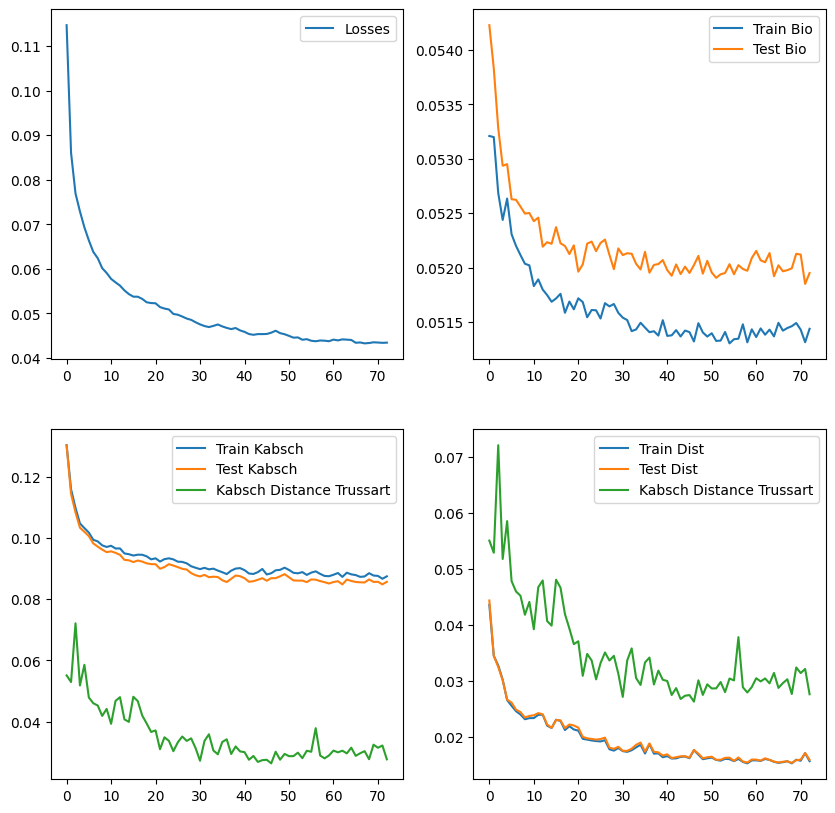

In [11]:
plot_losses(losses, train_biological_losses_all_epochs, test_biological_losses_all_epochs, train_kabsch_losses_all_epochs, test_kabsch_losses_all_epochs, trussart_test_kabsch_losses_all_epochs, train_distance_losses_all_epochs, test_distance_losses_all_epochs)


tensor(0.0002)
linear_encoder_layer_1.weight
tensor(0.0004)
linear_encoder_layer_2.weight
tensor(0.0036)
linear_encoder_layer_3.weight
tensor(3.1952e-06)
linear_bin_layer.weight


/Users/hva/Documents/3D-Chromatin/Chromatin3D/Data_Tools/Data_Plotting.py:107: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



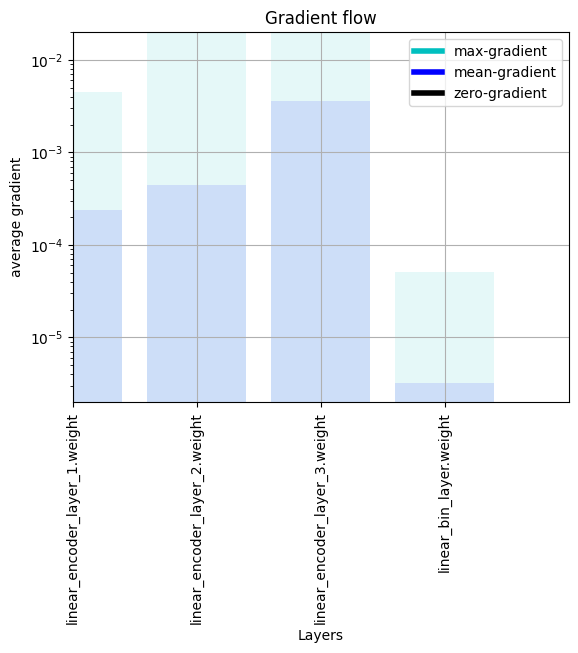

In [12]:
plot_grad_flow(model.named_parameters())

In [13]:
GRAPH_TESTED = 0

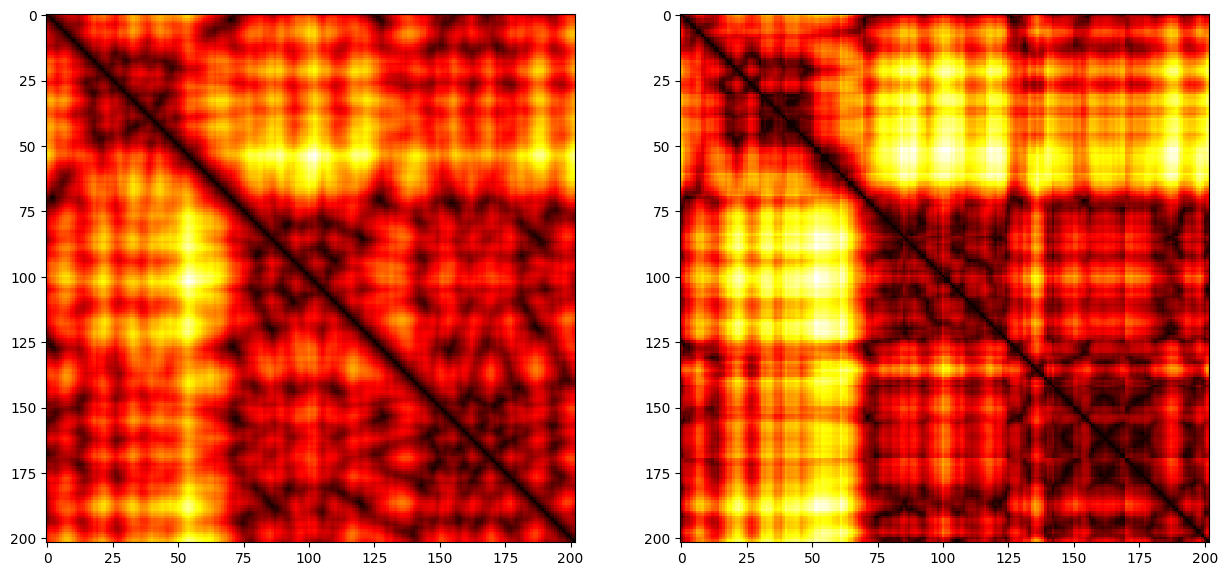

In [14]:
ground_truth_matrix = test_true_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
reconstruction_matrix = test_pred_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
plot_test_distance_matrix(ground_truth_matrix, reconstruction_matrix)

In [15]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.07142510200677717


<Figure size 50000x50000 with 0 Axes>

In [16]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]
pred_structure_unit_ball, true_structure_unit_ball = \
            kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)
d = np.negative(np.log(np.mean(np.divide(np.abs(pred_structure_unit_ball - true_structure_unit_ball),np.abs(true_structure_unit_ball)), axis=1)))

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = d
color1 = 'Viridis'
color2 = 'rainbow'
plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.07142510200677717


<Figure size 50000x50000 with 0 Axes>

In [17]:
random_structure = np.random.random((202,3))
test_true_structure = test_true_structures[GRAPH_TESTED]
print(lddt(torch.from_numpy(test_pred_structure_superposed).unsqueeze(0), torch.from_numpy(test_true_structure_superposed).unsqueeze(0)))

random_structure_superposed, true_to_random_structure_superposed = \
        kabsch_superimposition_numpy(random_structure, test_true_structure, EMBEDDING_SIZE)

print(lddt(torch.from_numpy(random_structure_superposed).unsqueeze(0), torch.from_numpy(true_to_random_structure_superposed).unsqueeze(0)))
#print(test_true_structures[GRAPH_TESTED].shape)


tensor([0.7958], dtype=torch.float64)
tensor([0.5416], dtype=torch.float64)


In [18]:
make_gif("", "gifs/trussart_linear.gif")

In [19]:
# Trussart perfect structure
trussart_true_structure = np.mean(trussart_structures, axis=0)

# Trussart predicted structure
torch_trussart_hic = torch.FloatTensor(trussart_hic)
torch_trussart_hic = torch.reshape(torch_trussart_hic, (1, NB_BINS, NB_BINS))
torch_trussart_hic = torch.repeat_interleave(torch_trussart_hic, BATCH_SIZE, 0)

trussart_pred_structure, trussart_pred_distance, trussart_pred_logits = model(torch_trussart_hic)
trussart_pred_structure = trussart_pred_structure.detach().numpy()[0]

# Superpose structure using Kabsch algorithm
trussart_pred_structure_superposed, trussart_true_structure_superposed = \
        kabsch_superimposition_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)

# Plot and compare the two structures
x_pred = trussart_pred_structure_superposed[:, 0]  
y_pred = trussart_pred_structure_superposed[:, 1]
z_pred = trussart_pred_structure_superposed[:, 2]

x_true = trussart_true_structure_superposed[:, 0]  
y_true = trussart_true_structure_superposed[:, 1]
z_true = trussart_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)))

Kabsch distance is 0.02719038468297398


<Figure size 50000x50000 with 0 Axes>

In [20]:
confidence_metrics, pLLDTs = get_confidence_metrics(trussart_pred_logits.detach().numpy()[0])
print(confidence_metrics)

value = lddt(torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0),torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0), per_residue=True)
print(torch.mean(value))

#print(pLLDTs)
#print(value)

85.58350522747233
tensor(0.8679, dtype=torch.float64)


In [21]:
color = 'rainbow'
plot_pred_conf(trussart_pred_structure_superposed, pLLDTs, color)

In [22]:
####Max error to confidence interval
dmat_true = torch.sqrt(1e-10 + torch.sum(
    (torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0)[:, :, None] - torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0)[:, None, :])**2, axis=-1))
dmat_predicted = torch.sqrt(1e-10 + torch.sum(
    (torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0)[:, :, None] -
    torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0)[:, None, :])**2, axis=-1))

dists_to_score = (
    (dmat_true).type(torch.FloatTensor) *(1. - torch.eye(dmat_true.shape[1]))  
)

dist_l1 = torch.abs(dmat_true - dmat_predicted)
relative_error = torch.mean(torch.div(dist_l1, torch.abs(dmat_true))[0], dim=0)

print(relative_error.shape)
print(torch.topk(torch.mean(dist_l1[0],dim=0), k=10))
print(torch.topk(relative_error, k=10, largest=True))
print(np.argpartition(pLLDTs, 10)[:10])
print(torch.topk(value[0], k=10, largest=False))

torch.Size([202])
torch.return_types.topk(
values=tensor([0.3198, 0.2922, 0.2787, 0.2610, 0.2288, 0.2120, 0.1993, 0.1986, 0.1974,
        0.1819], dtype=torch.float64),
indices=tensor([ 30,  29,  31,  28,  32,  27,  87,  86,  26, 111]))
torch.return_types.topk(
values=tensor([0.3205, 0.3023, 0.2841, 0.2837, 0.2464, 0.2362, 0.2232, 0.2219, 0.2202,
        0.2185], dtype=torch.float64),
indices=tensor([ 30,  29,  28,  31,  32,  27,  26, 111, 131, 135]))
[194 195 189 190 191 192  45 188  48  50]
torch.return_types.topk(
values=tensor([0.6977, 0.7148, 0.7346, 0.7349, 0.7698, 0.7777, 0.7802, 0.7829, 0.7898,
        0.7924], dtype=torch.float64),
indices=tensor([30, 29, 31, 28, 32, 27, 86, 87, 26, 85]))


In [23]:
orig_model = model
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_test_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model = ModelWithTemperature(orig_model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model.set_temperature(valid_loader)
m = torch.nn.LogSoftmax(dim=1)
nll_criterion = torch.nn.BCEWithLogitsLoss()
print(nll_criterion(m(logits_test_temp), labels_test_temp).item())
logits_test_temps_scaled = scaled_model.temperature_scale(logits_test_temp)

print(nll_criterion(m(logits_test_temps_scaled), labels_test_temp).item())

Before temperature - NLL: 0.038
tensor(0.7915, grad_fn=<MulBackward0>)
tensor(0.7908, grad_fn=<MulBackward0>)
tensor(0.7902, grad_fn=<MulBackward0>)
tensor(0.7896, grad_fn=<MulBackward0>)
tensor(0.7890, grad_fn=<MulBackward0>)
tensor(0.7884, grad_fn=<MulBackward0>)
tensor(0.7878, grad_fn=<MulBackward0>)
tensor(0.7873, grad_fn=<MulBackward0>)
tensor(0.7867, grad_fn=<MulBackward0>)
tensor(0.7861, grad_fn=<MulBackward0>)
tensor(0.7855, grad_fn=<MulBackward0>)
tensor(0.7850, grad_fn=<MulBackward0>)
tensor(0.7844, grad_fn=<MulBackward0>)
tensor(0.7839, grad_fn=<MulBackward0>)
tensor(0.7833, grad_fn=<MulBackward0>)
tensor(0.7828, grad_fn=<MulBackward0>)
tensor(0.7823, grad_fn=<MulBackward0>)
tensor(0.7818, grad_fn=<MulBackward0>)
tensor(0.7813, grad_fn=<MulBackward0>)
tensor(0.7808, grad_fn=<MulBackward0>)
tensor(0.7803, grad_fn=<MulBackward0>)
tensor(0.7798, grad_fn=<MulBackward0>)
tensor(0.7793, grad_fn=<MulBackward0>)
tensor(0.7789, grad_fn=<MulBackward0>)
tensor(0.7784, grad_fn=<MulBackw

In [24]:
confidence_metric_scaled, plddt_scaled = scale_logits(trussart_pred_logits, scaled_model, BATCH_SIZE, NB_BINS)
print(confidence_metric_scaled)
print(plddt_scaled)

86.01638385796403
[84.54061572 84.46255591 85.01322006 85.38895231 85.50620018 85.51829203
 85.19174218 85.44427389 85.58522405 85.67822821 85.75993095 85.64820199
 85.59408953 85.28934087 85.571032   85.77917066 86.27475279 86.76802695
 86.32554103 86.05046937 86.14809406 86.21687581 86.07220474 85.8739161
 85.76361642 85.90771156 85.6579783  85.79248803 85.8752642  85.97800239
 86.10943468 86.249394   86.10587286 86.12400665 86.0687242  85.85920663
 85.87433623 85.80414998 85.80387377 85.67486704 85.67683808 85.71611754
 85.55029543 85.47544064 84.79453024 84.08487495 84.08487495 84.24018727
 84.08487495 84.08487495 84.08487495 84.23925352 84.48266376 84.53564079
 84.76846457 84.97083133 85.23572997 85.96581515 86.29110395 86.55309558
 86.47614806 86.47205906 86.30254772 85.86132289 85.09221728 84.99384911
 84.82767316 84.44852804 84.60312057 85.04027851 85.30572695 85.35150877
 85.40235838 85.17554024 85.32699218 85.42960649 85.6339246  85.87793275
 86.13398045 86.19567868 86.334028

In [25]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, plddt_scaled)
print(mse_unscalled)
print(mse_scalled)

22.771794411648127
21.012991253142005


In [26]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

In [27]:
confidence_metric_iso, pLDDT_iso = isotonic_calibration(logits_test_temp, labels_test_temp, trussart_pred_logits)
print(confidence_metric_iso)
print(pLDDT_iso)

2.8878514987669632
3.3354670832259425
85.38048031105055
[83.33558072 83.14080413 84.09478411 84.69705177 84.83671773 84.9160472
 84.38033575 84.86350167 85.03814809 85.10769262 85.16100859 85.08956008
 85.0596085  84.53886171 84.90731623 85.12243307 85.63249713 86.30268478
 85.74398784 85.50582584 85.6115195  85.68624862 85.51901502 85.25720266
 85.16294166 85.31882188 85.09496558 85.20156193 85.25786521 85.40074673
 85.55519746 85.70798685 85.54826067 85.58855675 85.51747682 85.249818
 85.25738906 85.22183798 85.22168276 85.10585352 85.10693639 85.1392385
 85.01810075 84.89967965 83.64830108 83.17079376 83.17079376 82.75187674
 83.17079376 83.17079376 83.17079376 82.75129838 83.26301991 83.33057438
 83.67430431 84.11639759 84.48195193 85.17069407 85.58978776 85.94103491
 85.8108934  85.80944861 85.60951388 85.08082763 84.26340639 84.14442792
 83.7552247  83.1580987  83.39462501 84.18910064 84.5914906  84.63080258
 84.65555637 84.40341116 84.60189499 84.6598364  84.95504324 85.10000736

In [28]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, pLDDT_iso)
print(mse_unscalled)
print(mse_scalled)

22.771794411648127
23.83696438556323


In [29]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

In [30]:
confidence_metric_beta, pLDDT_beta = beta_calibration(logits_test_temp, labels_test_temp, trussart_pred_logits)
print(confidence_metric_beta)
print(pLDDT_beta)

2.8878514987669632
2.8815617158074582
85.3155179697369
[83.45494539 83.35845794 84.04493649 84.52174701 84.67671889 84.70215306
 84.29425857 84.62318841 84.80707218 84.92881114 85.03594758 84.88943696
 84.81871252 84.42193656 84.75413885 85.00806686 85.64419363 86.28126661
 85.75201507 85.41782073 85.54616803 85.63649799 85.44642692 85.18569185
 85.04078028 85.23011536 84.90229672 85.07869011 85.18748105 85.32254752
 85.49534297 85.67913012 85.49069898 85.51453885 85.44185963 85.16633375
 85.18620857 85.09399413 85.09364092 84.92439094 84.9269805  84.97849045
 84.76141012 84.66377568 83.78646028 82.87789279 82.87789279 83.08070724
 82.87789279 82.87789279 82.87789279 83.07954547 83.37775717 83.44283154
 83.729483   83.97977312 84.30892731 85.22475845 85.6361794  85.9687227
 85.87094075 85.8657478  85.65065071 85.09294266 84.13042919 84.00830233
 83.80265983 83.33591486 83.52575776 84.06588523 84.39623293 84.45535534
 84.51903299 84.23400889 84.42273908 84.55096208 84.81253801 85.116608

In [31]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, pLDDT_beta)
print(mse_unscalled)
print(mse_scalled)

22.771794411648127
23.92975783838049


In [32]:
color = 'rainbow'
plot_pred_conf(trussart_pred_structure_superposed, plddt_scaled, color)

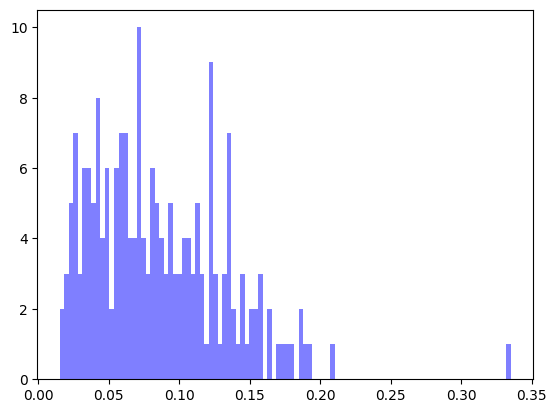

mean: 0.08570700227259902
median: 0.0778820532410772
variance: 0.002228803311545499


In [33]:
plot_hist_kabsch_distances(test_size, test_true_structures, test_pred_structures, EMBEDDING_SIZE)

In [34]:
RESULTS_ROOT = '../../saved_results/synthetic_biological_trussart_uniform_conf/linear/'
LAMBDA_CONFIGURATION = str(LAMBDA_BIO) + '_' + str(LAMBDA_KABSCH)

In [35]:
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_conf_linear_losses_' + LAMBDA_CONFIGURATION + '.txt', losses)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_conf_linear_train_biological_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', train_biological_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_conf_linear_test_biological_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', test_biological_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_conf_linear_train_kabsch_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', train_kabsch_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_conf_linear_test_kabsch_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', test_kabsch_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_conf_linear_train_distance_losses_all_epochs_' +
           LAMBDA_CONFIGURATION + '.txt', train_distance_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_conf_linear_test_distance_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', test_distance_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_conf_linear_trussart_test_kabsch_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', trussart_test_kabsch_losses_all_epochs)

In [36]:
torch.save(model, 
           '../../saved_models/synthetic_biological_trussart_uniform_conf/linear/synthetic_biological_trussart_uniform_linear_model_' + 
           LAMBDA_CONFIGURATION + '.pt')